<a href="https://colab.research.google.com/github/Rafael-Franca90/MVP/blob/main/MVP_Pedidos_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP Análise de Dados e Boas Práticas

**Nome:** Rafael Moreno Soledade França

**Matrícula:** 4052025000202

**Dataset:** df_pedidos e df_insucesso

# Descrição do Problema

O cumprimento do prazo de entrega de pedidos é um fator crítico para a satisfação do cliente e a eficiência operacional de qualquer empresa. Neste contexto, o objetivo deste projeto é realizar uma análise exploratória e um pré-processamento de dados relacionados ao cumprimento do SLA (Service Level Agreement) de entregas da empresa, com base em pedidos realizados no mês de abril de 2025.

# Hipóteses do Problema



A seguir, estão as perguntas que guiarão nossa análise:

*   Existem transportadoras que estão entregando fora do prazo sem motivo de insucesso?
*   Existe algum dia da semana que tem uma maior concentração de pedidos entregues em atrasos?
*   Certos tipos de insucesso acontecem mais em algumas modalidades de entregas?


# Tipo de Problema

Este projeto se enquadra inicialmente em dois tipos de análise:

* Análise Descritiva, que busca entender o que está acontecendo com os dados de entrega — frequência de atrasos, distribuição por cidade, transportadora, dia da semana, etc.

* Análise Diagnóstica, que vai além da descrição e tenta responder por que os atrasos acontecem, por meio da investigação de padrões, cruzamento com os dados de insucesso e identificação de causas recorrentes.

No entanto, como etapa preparatória para um modelo de machine learning supervisionado (regressão logística), esta análise também contempla a criação da variável-alvo binária atraso, que será utilizada futuramente para prever a probabilidade de atraso em novos pedidos.

Assim, embora este notebook ainda se concentre em análises exploratórias e diagnósticas, já está estruturado para evoluir em direção a uma abordagem preditiva, com foco em apoiar a tomada de decisão e a gestão proativa da operação logística.

# Seleção de Dados

A análise se baseia em duas fontes de dados principais:

*   A df_pedidos, que contém informações operacionais sobre os pedidos, como data prometida, data de entrega, canal de venda, transportadora, filial, entre outros.
*   A df_insucesso, que descreve os casos em que houve falha ou dificuldade na entrega, classificando o tipo de insucesso ocorrido.


A partir dessas informações, buscamos identificar padrões, anomalias e fatores que impactam diretamente o cumprimento do prazo de entrega, bem como compreender os principais motivos de falhas logísticas.

# Atributos dos Datasets



* **df_pedidos**  
>* Data_Performance: Data prometida de entrega ao cliente.
>* Cidade: Cidade de destino da entrega.
>* Documento: Número identificador único do pedido.
>* Canal: Canal de origem da venda (On, Off).
>* Transportador: Empresa responsável pelo transporte.
>* Modadalidade: Tipo/modalidade de entrega.
>* DataExpedicao: Data em que o pedido saiu do centro de distribuição.
>* Data_Limite_ExpedicaoETL: Prazo interno para expedição.
>* StatusDoPedido: Situação atual do pedido (ex: Encerrado).
>* DataEntregaCliente: Data efetiva da entrega.
>* DataIntegracao: Data de aprovação do pedido

* **df_insucesso**  
>* Documento: Número do pedido (chave para cruzamento).
>* DatadoTracking: Data do registro do insucesso.
>* DescricaoDoTracking: Descrição detalhada do motivo.
>* Insucesso: Macroclassificação da falha (Cliente, Transporte, Loja, etc.)

#Entrega de Pedidos — EDA, Pré-processamento & Diagnóstico


##Importação de bibliotecas
Importação das bibliotecas que serão usadas nesse notebook

In [203]:
#Instalação do imbalanced-learn para previnir erro
!pip install -q imbalanced-learn

In [155]:

#Manipulação
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Utilizado para preparar o dataframe para posterior projeto de ML.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# Utilitario
from IPython.display import Markdown, display


##Carregando bases de dados
Carregamento dos dataframes que estão alocados no github


In [156]:
#URLs do GitHub

URL_PEDIDOS   = 'https://raw.githubusercontent.com/Rafael-Franca90/MVP/main/Base.csv'
URL_INSUCESSO = 'https://raw.githubusercontent.com/Rafael-Franca90/MVP/main/Insucesso.csv'

#Carregamento
df_pedidos = pd.read_csv(URL_PEDIDOS, sep=';', encoding='latin1')
df_insucesso = pd.read_csv(URL_INSUCESSO, sep=';', encoding='utf-8')

Tamanho dos dataframes

In [157]:
print('Pedidos:', df_pedidos.shape, '| Insucesso:', df_insucesso.shape)

Pedidos: (82184, 11) | Insucesso: (13236, 4)


##.1 Exploração de Dados (EDA) Df_Pedidos



### 1. Estrutura das colunas Df_Pedidos
Dados iniciais

In [158]:
df_pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82184 entries, 0 to 82183
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Data_Performance     82184 non-null  object
 1   Cidade               82184 non-null  object
 2   Documento            82184 non-null  int64 
 3   Canal                82184 non-null  object
 4   Transportador        74165 non-null  object
 5   Modadalidade         82184 non-null  object
 6   DataExpedicao        72337 non-null  object
 7   DataLimiteExpedicao  81763 non-null  object
 8   StatusDoPedido       82184 non-null  object
 9   DataEntregaCliente   72299 non-null  object
 10  DataIntegracao       82184 non-null  object
dtypes: int64(1), object(10)
memory usage: 6.9+ MB


Contar os Nulos

In [159]:

print("\nResumo de valores nulos e não nulos por coluna:")
null_counts = df_pedidos.isnull().sum()
notnull_counts = df_pedidos.notnull().sum()

df_null_summary = pd.DataFrame({
    'Coluna': df_pedidos.columns,
    'Nulos': null_counts.values,
    'Não Nulos': notnull_counts.values
})

print(df_null_summary)


Resumo de valores nulos e não nulos por coluna:
                 Coluna  Nulos  Não Nulos
0      Data_Performance      0      82184
1                Cidade      0      82184
2             Documento      0      82184
3                 Canal      0      82184
4         Transportador   8019      74165
5          Modadalidade      0      82184
6         DataExpedicao   9847      72337
7   DataLimiteExpedicao    421      81763
8        StatusDoPedido      0      82184
9    DataEntregaCliente   9885      72299
10       DataIntegracao      0      82184


### 2. Formatações necessarias
Transformação das devidas colunas no formato de data, e coluna Documento em string (não vou utiliza-la como numero)

In [160]:
# Conversão da coluna documento em string
df_pedidos["Documento"] = df_pedidos["Documento"].astype("string")

# Conversão das colunas em data
date_cols = ['DataEntregaCliente', 'DataLimiteExpedicao', 'Data_Performance', 'DataExpedicao', 'DataIntegracao']
for col in date_cols:
    df_pedidos[col] = pd.to_datetime(df_pedidos[col], errors='coerce', dayfirst=True)

In [204]:
# Verificar novamente
df_pedidos[date_cols].head()
print('\nDepois da conversão:')
df_pedidos.info()
df_pedidos.head(5)


Depois da conversão:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72204 entries, 0 to 72203
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Data_Performance     72204 non-null  datetime64[ns]
 1   Cidade               72204 non-null  object        
 2   Documento            72204 non-null  string        
 3   Canal                72204 non-null  object        
 4   Transportador        72189 non-null  object        
 5   Modadalidade         72204 non-null  object        
 6   DataExpedicao        71540 non-null  datetime64[ns]
 7   DataLimiteExpedicao  72204 non-null  datetime64[ns]
 8   StatusDoPedido       72204 non-null  object        
 9   DataEntregaCliente   72204 non-null  datetime64[ns]
 10  DataIntegracao       72204 non-null  datetime64[ns]
 11  atraso               72204 non-null  bool          
 12  dias_atraso          72204 non-null  int64         
 13  faixa_atr

,Data_Performance,Cidade,Documento,Canal,Transportador,Modadalidade,DataExpedicao,DataLimiteExpedicao,StatusDoPedido,DataEntregaCliente,DataIntegracao,atraso,dias_atraso,faixa_atraso
0,2025-04-01,SAO PAULO,2756432071,On,A,Carro,2025-04-01,2025-04-01,ENCERRADO,2025-04-01,2025-03-28,False,0,No Prazo
1,2025-04-02,SAO PAULO,2756757711,On,B,Carro,2025-04-02,2025-04-02,ENCERRADO,2025-04-03,2025-03-29,True,1,1 dia
2,2025-04-02,SAO PAULO,2757318421,On,B,Carro,2025-04-02,2025-04-02,ENCERRADO,2025-04-04,2025-03-31,True,2,2 dias
3,2025-04-03,GUARULHOS,2757536071,Off,C,Carro,2025-04-03,2025-04-03,ENCERRADO,2025-04-03,2025-04-01,False,0,No Prazo
4,2025-04-07,SAO PAULO,2758708361,On,A,Carro,2025-04-07,2025-04-07,ENCERRADO,2025-04-07,2025-04-05,False,0,No Prazo


### 3. Verificar duplicidades
Preciso garantir linhas completas distintas e com a coluna Documento distinto, posteriormente irei utiliza-la como chave primaria.


In [162]:
mask_dups = df_pedidos.duplicated(subset='Documento', keep='first')

n_dups = mask_dups.sum()
print(f"{n_dups:,} registros duplicados identificados em 'Documento'.")

204 registros duplicados identificados em 'Documento'.


In [163]:
df_pedidos = (
    df_pedidos
    .loc[~mask_dups]          # mantém só quem NÃO é duplicado excedente
    .reset_index(drop=True)   # limpa o índice para evitar buracos
)

print(f"Dataset final: {len(df_pedidos):,} linhas — 100 % únicas por Documento.")

Dataset final: 81,980 linhas — 100 % únicas por Documento.


### 4. Criando flag atraso e KPI inicial
Criação do KPI de atraso para analises iniciais


Verificar se todas as linhas das colunas DataEntregaCliente e Data_Performance (que são premissas para calcular a flag de atraso) estão preenchidas.

In [164]:
# Verifica valores ausentes
faltantes = df_pedidos[['DataEntregaCliente', 'Data_Performance']].isna().sum()

# Mostra o total de linhas faltantes por coluna
print("🔍 Valores ausentes por coluna:")
print(faltantes)

🔍 Valores ausentes por coluna:
DataEntregaCliente    9776
Data_Performance         0
dtype: int64


Sera necessario remover para não causar distorções nas analises

In [165]:
# Remove pedidos com falha em uma das duas datas essenciais
df_pedidos = df_pedidos.dropna(subset=['DataEntregaCliente', 'Data_Performance']).reset_index(drop=True)

Agora eu crio a sinalização de atraso

In [166]:
# Criando flag binária de atraso
df_pedidos['atraso'] = (df_pedidos['DataEntregaCliente'] > df_pedidos['Data_Performance']).astype(int)



In [167]:
# Cálculo da % de atraso
impacto_total = df_pedidos['atraso'].mean() * 100
print(f' % de pedidos com atraso: {impacto_total:.1f}%')

 % de pedidos com atraso: 8.9%


### 5. Distribuição de Atraso
Esta seção avalia a distribuição dos atrasos


Verifico a distribuição da classe atraso.

In [168]:
# Distribuição detalhada
contagem = df_pedidos['atraso'].value_counts().sort_index()
percentual = df_pedidos['atraso'].value_counts(normalize=True).sort_index() * 100

# Exibindo distribuição
print("\nDistribuição de atrasos:")
for classe in contagem.index:
    nome = "No prazo" if classe == 0 else "Atrasado"
    print(f"{nome}: {contagem[classe]} pedidos ({percentual[classe]:.1f}%)")


Distribuição de atrasos:
No prazo: 65785 pedidos (91.1%)
Atrasado: 6419 pedidos (8.9%)


#### Representatividade de atraso por categoria


Top 3 com maior atraso - Transportador


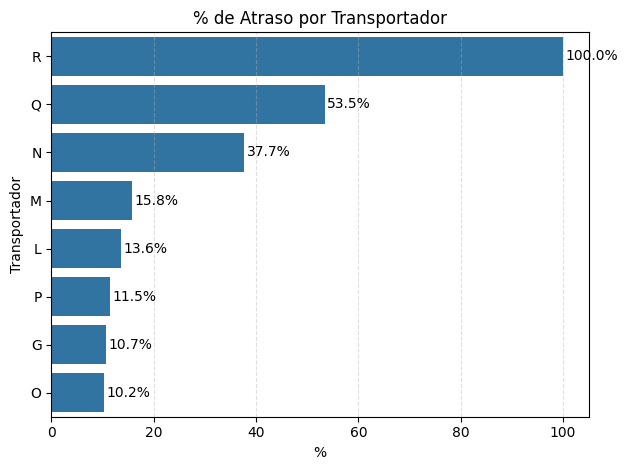

R    100.000000
Q     53.461538
N     37.660819

Top 3 com maior atraso - Canal


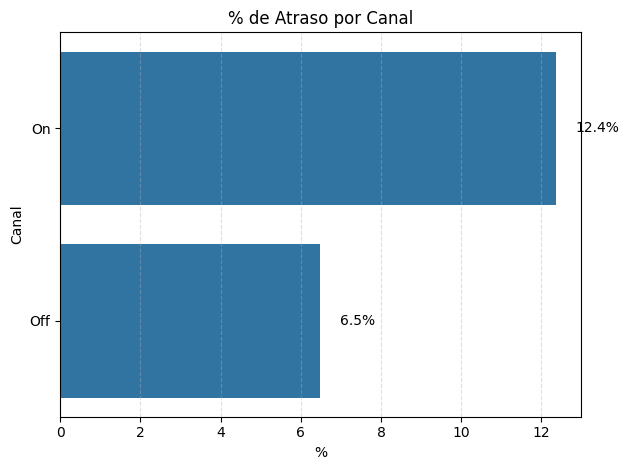

On     12.358676
Off     6.488210

Top 3 com maior atraso - Cidade


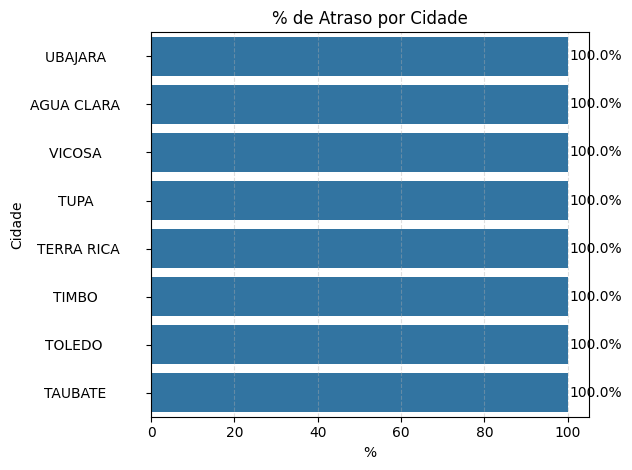

UBAJARA            100.0
AGUA CLARA         100.0
VICOSA             100.0


In [169]:
# Definir função
def plot_atraso(col, top=8):
    taxa = (
        df_pedidos.groupby(col)['atraso']
        .mean()
        .sort_values(ascending=False) * 100
    )

    top_taxa = taxa.head(top)
    ax = sns.barplot(y=top_taxa.index, x=top_taxa.values)

    # Adiciona os valores nas barras
    for i, v in enumerate(top_taxa.values):
        ax.text(v + 0.5, i, f'{v:.1f}%', va='center')

    plt.title(f'% de Atraso por {col}')
    plt.xlabel('%'); plt.ylabel(col)
    plt.grid(True, axis='x', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

    return top_taxa.head(3)

# Gerar gráfico para principais categorias
for col in ['Transportador', 'Canal', 'Cidade']:
    print(f'\nTop 3 com maior atraso - {col}')
    print(plot_atraso(col).to_string(header=False))


Os transportadores R, Q e N, aparecem com os maiores em indice de atraso.
O canal On tem quas e o dobro de percentual de insucesso comparado ao Off.
Existem varias cidades que 100% de atraso no SLA.

#### Distribuição da volumetria de atrasos

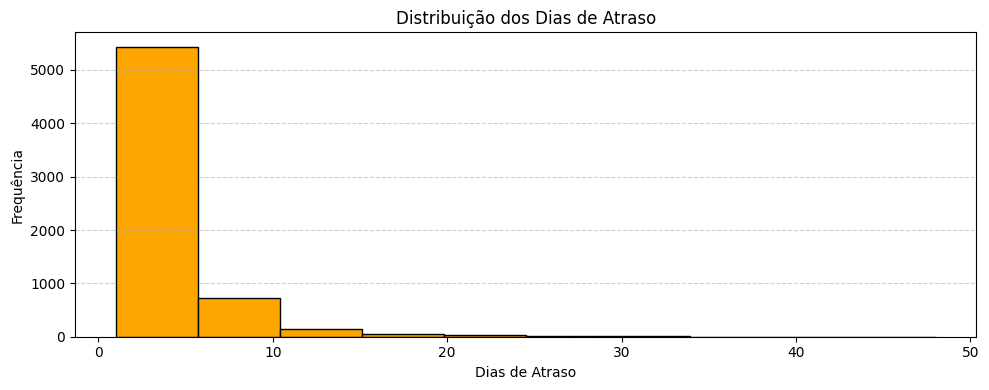

In [170]:
# Gerar coluna com dias de atraso (apenas onde houve atraso)
df_pedidos['dias_atraso'] = (
    (df_pedidos['DataEntregaCliente'] - df_pedidos['Data_Performance'])
    .dt.days.clip(lower=0)
)

# Histograma da distribuição de dias de atraso
plt.figure(figsize=(10, 4))
plt.hist(
    df_pedidos[df_pedidos['atraso'] == 1]['dias_atraso'],
    color='orange', edgecolor='black'
)
plt.title('Distribuição dos Dias de Atraso')
plt.xlabel('Dias de Atraso'); plt.ylabel('Frequência')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Sera necessario criar faixas de atrasos

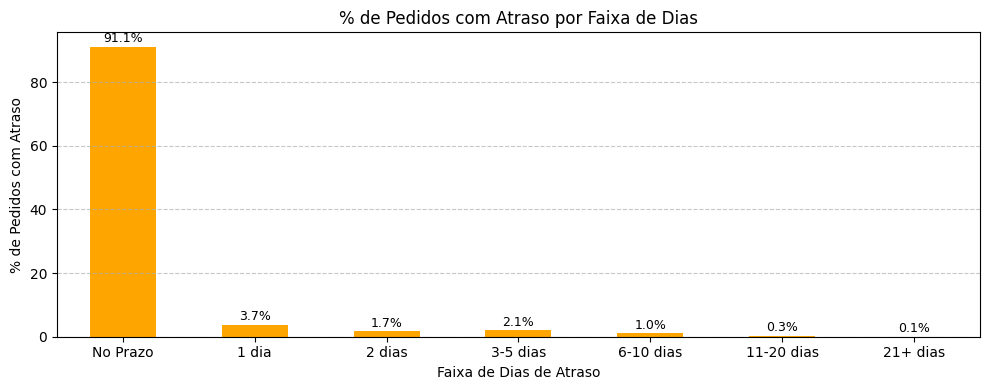

In [171]:
# Define as faixas de dias de atraso
bins = [0 ,1, 2, 3, 6, 11, 21, np.inf]
labels = ['No Prazo', '1 dia', '2 dias', '3-5 dias', '6-10 dias', '11-20 dias', '21+ dias']


# Classifica os atrasos em faixas
df_pedidos['faixa_atraso'] = pd.cut(
    df_pedidos['dias_atraso'],
    bins=bins,
    labels=labels,
    right=False
)

# Calcula percentual por faixa
frequencias_pct = (df_pedidos['faixa_atraso'].value_counts(normalize=True)
                   .sort_index() * 100)

# Gráfico de barras em percentual
plt.figure(figsize=(10, 4))
frequencias_pct.plot(kind='bar', color='orange')
plt.title('% de Pedidos com Atraso por Faixa de Dias')
plt.xlabel('Faixa de Dias de Atraso')
plt.ylabel('% de Pedidos com Atraso')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)

# Adiciona rótulo de valor em cima das barras
for i, valor in enumerate(frequencias_pct):
    plt.text(i, valor + 0.5, f'{valor:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


Maior parte dos atrasos se concentram em até 5 dias

#### Verificação de Outliers atraves de analise de quartis

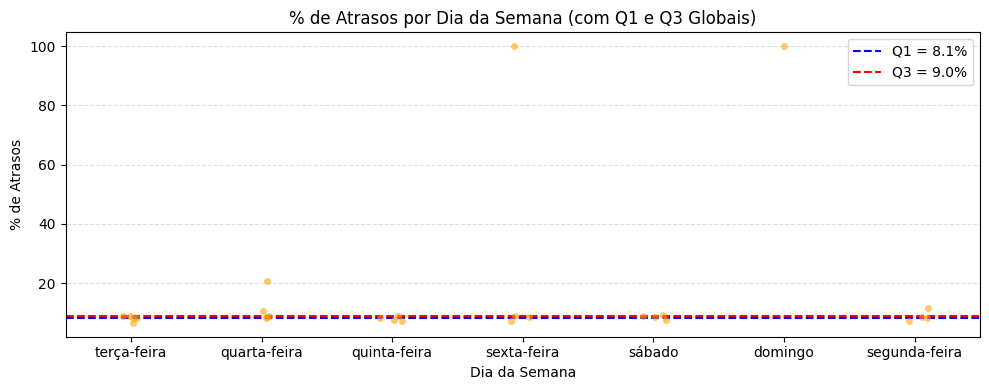

In [172]:
# Prepara os dados
df_pedidos['dias_atraso'] = (df_pedidos['DataEntregaCliente'] - df_pedidos['Data_Performance']).dt.days.clip(lower=0)
df_pedidos['atraso'] = df_pedidos['dias_atraso'] > 0

#Agrega por dia e calcula o percentual de atrasos
df_diario = (
    df_pedidos
    .set_index('Data_Performance')
    .resample('D')
    .agg(
        total_pedidos=('atraso', 'size'),
        atrasados=('atraso', 'sum')
    )
    .dropna()
)
df_diario['percentual_atrasos'] = df_diario['atrasados'] / df_diario['total_pedidos'] * 100

# Adiciona nome do dia da semana
weekday_map = {0: 'segunda-feira', 1: 'terça-feira', 2: 'quarta-feira',
               3: 'quinta-feira', 4: 'sexta-feira', 5: 'sábado', 6: 'domingo'}
df_diario['weekday_name'] = df_diario.index.dayofweek.map(weekday_map)

# Calcula quartis do percentual de atrasos
q1_percent = df_diario['percentual_atrasos'].quantile(0.25)
q3_percent = df_diario['percentual_atrasos'].quantile(0.75)

# Visualiza gráfico com Q1 e Q3
plt.figure(figsize=(10, 4))
sns.stripplot(data=df_diario, x='weekday_name', y='percentual_atrasos', color='orange', alpha=0.6, jitter=True)
plt.axhline(q1_percent, color='blue', linestyle='--', label=f'Q1 = {q1_percent:.1f}%')
plt.axhline(q3_percent, color='red', linestyle='--', label=f'Q3 = {q3_percent:.1f}%')
plt.title('% de Atrasos por Dia da Semana (com Q1 e Q3 Globais)')
plt.xlabel('Dia da Semana')
plt.ylabel('% de Atrasos')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

In [173]:
# Exibe datas fora da faixa interquartil
print(f"\n🔵 Datas com % de atrasos abaixo de Q1 ({q1_percent:.1f}%):")
print(df_diario[df_diario['percentual_atrasos'] < q1_percent][['percentual_atrasos']])

print(f"\n🔴 Datas com % de atrasos acima de Q3 ({q3_percent:.1f}%):")
print(df_diario[df_diario['percentual_atrasos'] > q3_percent][['percentual_atrasos']])


🔵 Datas com % de atrasos abaixo de Q1 (8.1%):
                  percentual_atrasos
Data_Performance                    
2025-04-01                  8.060373
2025-04-05                  7.488431
2025-04-10                  7.140518
2025-04-11                  7.142857
2025-04-24                  7.624919
2025-04-28                  7.070707
2025-04-29                  6.575604

🔴 Datas com % de atrasos acima de Q3 (9.0%):
                  percentual_atrasos
Data_Performance                    
2025-04-13                100.000000
2025-04-16                 10.604591
2025-04-18                100.000000
2025-04-19                  8.975713
2025-04-21                 11.659808
2025-04-26                  9.226646
2025-04-30                 20.822704


##  Análise Descritiva df_Pedidos
*   Existem 8,9% de registros com atraso. Será necessário aplicar balanceamento de classes antes de seguir com o projeto de machine learning baseado em Regressão Logística.
*   A maior parte dos pedidos é entregue no prazo ou com atraso de até 5 dias, o que representa uma concentração leve, porém recorrente.
*   As transportadoras R, Q e N concentram os maiores percentuais de atraso, com destaque absoluto para a transportadora R (100%).
*   O canal "On" (digital) apresenta quase o dobro do indice atraso em comparação ao canal "Off", sinalizando possíveis falhas operacionais no ambiente online.
*   Cidades como UBAJARA, VIÇOSA e TAUBATÉ possuem 100% dos pedidos com atraso, evidenciando gargalos locais críticos.
*   A análise por dia da semana revela que quartas, sextas e domingos concentram os maiores percentuais de atraso, acima do terceiro quartil (Q3) da distribuição global.

**Importante** destacar que existem pedidos sem data de entrega registrada, o que impede o cálculo da flag de SLA para essas ocorrências. Esses casos foram desconsiderados nas análises de atraso para garantir a integridade dos resultados.

##.2 Exploração de Dados (EDA) – df_insucesso

### 1. Estrutura das colunas do df_insucesso
Dados iniciais

In [205]:
df_insucesso.info()
df_insucesso.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9216 entries, 0 to 9215
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Documento            9216 non-null   string        
 1   DatadoTracking       9216 non-null   datetime64[ns]
 2   DescricaoDoTracking  9216 non-null   object        
 3   Insucesso            9216 non-null   object        
dtypes: datetime64[ns](1), object(2), string(1)
memory usage: 288.1+ KB


,Documento,DatadoTracking,DescricaoDoTracking,Insucesso
0,2692080901,2024-11-22,DESTINATARIO AUSENTE NA PRIMEIRA TENTATIVA,Cliente
1,2714524911,2024-12-04,PERDA LOGISTICA,Pendencia
2,2716159471,2024-12-08,MERCADORIA PENDENTE,Pendencia
3,2721653491,2025-01-27,PERDA LOGISTICA,Pendencia
4,2716533781,2025-01-29,DOCUMENTO NAO LIBERADO ATE O MOMENTO DA EMISSA...,Loja


### 2. Formatações necessarias
Transformação das colunas de data e string.

In [175]:
df_insucesso['DatadoTracking'] = pd.to_datetime(
    df_insucesso['DatadoTracking'],
    errors='coerce', dayfirst=True
)
df_insucesso['Documento'] =  df_insucesso['Documento'].astype("string")

### 3. Verificar duplicidades
Verificar se tem alguma duplicidade, pois posteriomente terei que identificar os insucessos pela coluna documento  no dataset de pedidos

In [176]:
#Verificar duplicatas exatas
df_dupsInsucesso = (
    df_insucesso[df_insucesso.duplicated(keep=False)]
        .sort_values('Documento')
)

print(
    f"Duplicatas exatas: {len(df_dupsInsucesso):,} linhas  "
    f"({len(df_dupsInsucesso) / len(df_insucesso):.2%} do dataset)"
)
df_dupsInsucesso.head()


Duplicatas exatas: 2,586 linhas  (19.54% do dataset)


,Documento,DatadoTracking,DescricaoDoTracking,Insucesso
3703,2714524911,2024-12-11,PERDA LOGISTICA,Pendencia
3972,2714524911,2024-12-11,PERDA LOGISTICA,Pendencia
4024,2714524911,2024-12-04,PERDA LOGISTICA,Pendencia
4011,2714524911,2024-12-04,PERDA LOGISTICA,Pendencia
1390,2716159471,2025-02-21,PERDA LOGISTICA,Pendencia


Foi constatado que tem duplicidade de numero de documento. Terei que tratar essa coluna. Seguirei identificando apenas o primeiro insucesso de cada documento.

In [177]:
# Ordena do mais antigo para o mais recente
df_insucesso = df_insucesso.sort_values(by='DatadoTracking')

# Mantém apenas o primeiro registro (menor data) por Documento
df_insucesso = df_insucesso.drop_duplicates(subset='Documento', keep='first').reset_index(drop=True)

### 4. Motivos de insucesso mais frequentes
Grafico que monto para exibir a quantidade de insucesso por Macro motivo


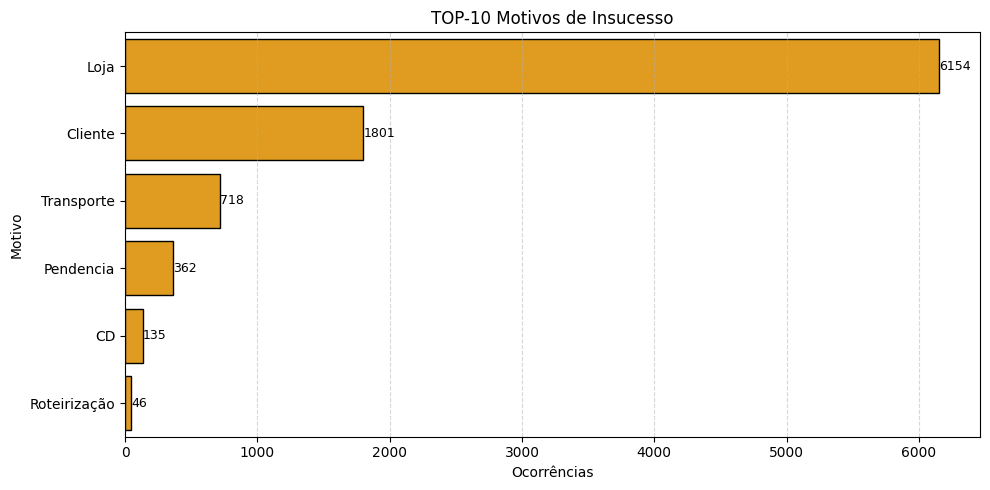

In [178]:
top_mot = df_insucesso['Insucesso'].value_counts().head(10)

plt.figure(figsize=(10, 5))
ax = sns.barplot(y=top_mot.index, x=top_mot.values, color='orange', edgecolor='black')

# Adiciona os valores numéricos no fim de cada barra
for i, v in enumerate(top_mot.values):
    ax.text(v + 1, i, str(v), color='black', va='center', fontsize=9)

plt.title('TOP-10 Motivos de Insucesso')
plt.xlabel('Ocorrências')
plt.ylabel('Motivo')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### 5. Linha do tempo dos insucessos
Grafico onde mostra a quantidade de insucessos por data

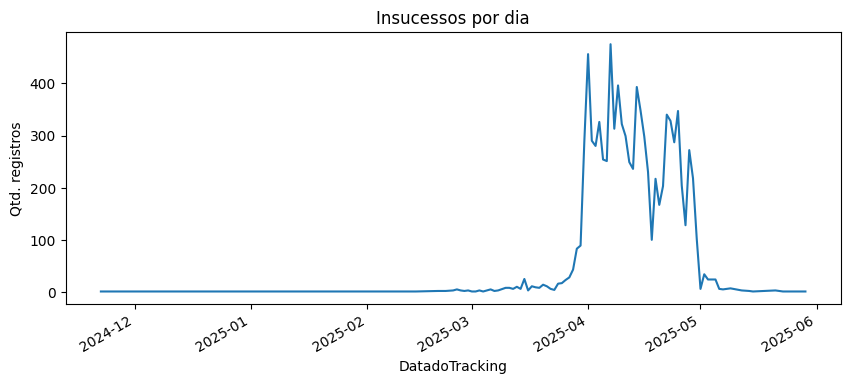

In [179]:
# Série diária, filtrando zeros/nulos
serie_diaria = (
    df_insucesso
        .set_index('DatadoTracking')['Documento']
        .resample('D').count()
        .loc[lambda s: s > 0]
)

# Gráfico de linha
serie_diaria.plot(figsize=(10,4))
plt.ylabel('Qtd. registros')
plt.title('Insucessos por dia')
plt.show()


##  Analise Descritiva do df_insucesso

*  Foram identicados linhas com a coluna documento duplicidade, esta correto porque tiveram documentos com mais um insucesso, porem como preciso identificar o primeiro insucesso, fiz o devido tratamento para que seja possivel.

*  Os motivos mais frequentes de insucesso estão concentrados em "Loja" (6.154 ocorrências) e "Cliente" (1.801 ocorrências), o que sugere problemas operacionais recorrentes tanto no ponto de origem quanto na entrega final. Outros motivos como Transporte, Pendência, CD e Roteirização também aparecem, mas com menor representatividade.

##.3 Pré-processamento  
Etapa onde indentifico o primeiro motivo de insucesso. Nesta etapa eu utilizo de join entre df_pedidos e df_insucesso

### 1. Enriquecendo df_pedidos com o **primeiro** motivo de cada pedido


In [180]:
# ▶︎ garantir datetime
df_insucesso['DatadoTracking'] = pd.to_datetime(
    df_insucesso['DatadoTracking'], errors='coerce', dayfirst=True
)

# 0️⃣ selecionar o PRIMEIRO motivo por Documento
df_first_mot = (
    df_insucesso
      .sort_values('DatadoTracking')                # mais antigo primeiro
      .drop_duplicates(subset='Documento', keep='first')
      .rename(columns={
          'Insucesso'          : 'MotivoMacro',
          'DescricaoDoTracking': 'MotivoDescricao'
      })
      [['Documento', 'MotivoMacro', 'MotivoDescricao']]
)

# Merge left → mantém todos os pedidos
df_prep = df_pedidos.merge(df_first_mot, on='Documento', how='left')

# 🔄 preenche onde não houve join
df_prep['MotivoMacro']     = df_prep['MotivoMacro'].fillna('Sem Atraso Identificado')
df_prep['MotivoDescricao'] = df_prep['MotivoDescricao'].fillna('Sem Atraso Identificado')

### 2. Verificar valores nulos


In [181]:
cat_prep = df_prep.select_dtypes('object').columns.tolist()

sum_ins = (
    pd.DataFrame({
        'n_únicos'  : df_prep[cat_prep].nunique(),
        'missings'  : df_prep[cat_prep].isna().sum(),
        '%_missings': df_prep[cat_prep].isna().mean()*100
    })
    .sort_values('n_únicos', ascending=False)
)
display(sum_ins.style.format({'%_missings':'{:.1f}%'}))


,n_únicos,missings,%_missings
Cidade,1151,0,0.0%
MotivoDescricao,56,0,0.0%
Transportador,19,15,0.0%
MotivoMacro,7,0,0.0%
Modadalidade,5,0,0.0%
StatusDoPedido,3,0,0.0%
Canal,2,0,0.0%


In [182]:
df_prep

,Data_Performance,Cidade,Documento,Canal,Transportador,Modadalidade,DataExpedicao,DataLimiteExpedicao,StatusDoPedido,DataEntregaCliente,DataIntegracao,atraso,dias_atraso,faixa_atraso,MotivoMacro,MotivoDescricao
0,2025-04-01,SAO PAULO,2756432071,On,A,Carro,2025-04-01,2025-04-01,ENCERRADO,2025-04-01,2025-03-28,False,0,No Prazo,Sem Atraso Identificado,Sem Atraso Identificado
1,2025-04-02,SAO PAULO,2756757711,On,B,Carro,2025-04-02,2025-04-02,ENCERRADO,2025-04-03,2025-03-29,True,1,1 dia,Sem Atraso Identificado,Sem Atraso Identificado
2,2025-04-02,SAO PAULO,2757318421,On,B,Carro,2025-04-02,2025-04-02,ENCERRADO,2025-04-04,2025-03-31,True,2,2 dias,Sem Atraso Identificado,Sem Atraso Identificado
3,2025-04-03,GUARULHOS,2757536071,Off,C,Carro,2025-04-03,2025-04-03,ENCERRADO,2025-04-03,2025-04-01,False,0,No Prazo,Loja,DOCUMENTO NAO LIBERADO ATE O MOMENTO DA EMISSA...
4,2025-04-07,SAO PAULO,2758708361,On,A,Carro,2025-04-07,2025-04-07,ENCERRADO,2025-04-07,2025-04-05,False,0,No Prazo,Sem Atraso Identificado,Sem Atraso Identificado
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72199,2025-04-15,SAO PAULO,2761331141,On,E,Carro,2025-04-15,2025-04-15,ENCERRADO,2025-04-16,2025-04-13,True,1,1 dia,Sem Atraso Identificado,Sem Atraso Identificado
72200,2025-04-24,SAO PAULO,2762702921,On,B,Carro,2025-04-24,2025-04-24,ENCERRADO,2025-04-28,2025-04-17,True,4,3-5 dias,Sem Atraso Identificado,Sem Atraso Identificado
72201,2025-04-14,SAO PAULO,2761093651,Off,A,Carro,2025-04-14,2025-04-14,ENCERRADO,2025-04-14,2025-04-12,False,0,No Prazo,Sem Atraso Identificado,Sem Atraso Identificado
72202,2025-04-05,SAO PAULO,2757918851,Off,A,Carro,2025-04-05,2025-04-06,ENCERRADO,2025-04-08,2025-04-02,True,3,3-5 dias,Cliente,CLIENTE AUSENTE 2


## Analise  Diagnostica
Etapa onde exploro os dados para alcançar as respostas das hipoteses, olhando tambem para o tipo de problema.

### Dataframe final pós identificação do motivo de atraso.

In [183]:
df_prep.head()

,Data_Performance,Cidade,Documento,Canal,Transportador,Modadalidade,DataExpedicao,DataLimiteExpedicao,StatusDoPedido,DataEntregaCliente,DataIntegracao,atraso,dias_atraso,faixa_atraso,MotivoMacro,MotivoDescricao
0,2025-04-01,SAO PAULO,2756432071,On,A,Carro,2025-04-01,2025-04-01,ENCERRADO,2025-04-01,2025-03-28,False,0,No Prazo,Sem Atraso Identificado,Sem Atraso Identificado
1,2025-04-02,SAO PAULO,2756757711,On,B,Carro,2025-04-02,2025-04-02,ENCERRADO,2025-04-03,2025-03-29,True,1,1 dia,Sem Atraso Identificado,Sem Atraso Identificado
2,2025-04-02,SAO PAULO,2757318421,On,B,Carro,2025-04-02,2025-04-02,ENCERRADO,2025-04-04,2025-03-31,True,2,2 dias,Sem Atraso Identificado,Sem Atraso Identificado
3,2025-04-03,GUARULHOS,2757536071,Off,C,Carro,2025-04-03,2025-04-03,ENCERRADO,2025-04-03,2025-04-01,False,0,No Prazo,Loja,DOCUMENTO NAO LIBERADO ATE O MOMENTO DA EMISSA...
4,2025-04-07,SAO PAULO,2758708361,On,A,Carro,2025-04-07,2025-04-07,ENCERRADO,2025-04-07,2025-04-05,False,0,No Prazo,Sem Atraso Identificado,Sem Atraso Identificado


### Pivot de volumetria por motivo de insucesso


In [184]:
# Cria a tabela dinâmica
tabela_motivos = pd.pivot_table(
    df_prep,
    index='MotivoMacro',
    columns='faixa_atraso',
    values='Documento',
    aggfunc='count',
    margins=True,
    margins_name='Total',
    observed=False
)


# Ordena pela coluna "Total"
tabela_motivos = tabela_motivos.sort_values(by='Total', ascending=False)

# Exibe a tabela com valores absolutos
display(tabela_motivos)

faixa_atraso,No Prazo,1 dia,2 dias,3-5 dias,6-10 dias,11-20 dias,21+ dias,Total
MotivoMacro,,,,,,,,
Total,65785,2704,1241,1489,733,206,46,72204
Sem Atraso Identificado,64810,2351,944,804,293,67,15,69284
Cliente,271,77,132,454,275,86,19,1314
Transporte,116,205,103,110,102,21,2,659
Loja,485,34,20,44,14,8,3,608
Pendencia,87,25,22,42,21,10,4,211
CD,15,9,13,17,18,12,3,87
Roteirização,1,3,7,18,10,2,0,41


### Pivot de representatividade por motivo de insucesso



In [185]:
# Remove a linha "Total" da tabela original para o cálculo correto
tabela_motivos_sem_total = tabela_motivos.drop(index='Total')

# Total geral
total_geral = tabela_motivos.loc['Total', 'Total']

# Calcula percentuais em relação ao total geral
tabela_percentual = (tabela_motivos_sem_total / total_geral * 100).round(1)

# Cria a linha de totais por coluna (exceto "Total", que será fixo em 100%)
linha_total = tabela_motivos.loc['Total'].drop('Total') / total_geral * 100
linha_total['Total'] = 100.0  # fixa o total em 100%

# Adiciona a linha "Total" no final
tabela_percentual.loc['Total'] = linha_total.round(1)

# Exibe resultado
display(tabela_percentual)


faixa_atraso,No Prazo,1 dia,2 dias,3-5 dias,6-10 dias,11-20 dias,21+ dias,Total
MotivoMacro,,,,,,,,
Sem Atraso Identificado,89.8,3.3,1.3,1.1,0.4,0.1,0.0,96.0
Cliente,0.4,0.1,0.2,0.6,0.4,0.1,0.0,1.8
Transporte,0.2,0.3,0.1,0.2,0.1,0.0,0.0,0.9
Loja,0.7,0.0,0.0,0.1,0.0,0.0,0.0,0.8
Pendencia,0.1,0.0,0.0,0.1,0.0,0.0,0.0,0.3
CD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1
Roteirização,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1
Total,91.1,3.7,1.7,2.1,1.0,0.3,0.1,100.0


### Pivot de pedidos fora do prazo por macro motivo

In [186]:
# Seleciona colunas que representam atraso (todas, exceto 'No Prazo' e 'Total')
colunas_atraso = [col for col in tabela_percentual.columns if col not in ['No Prazo', 'Total']]

# Soma por linha apenas as colunas de atraso
tabela_percentual['% Atraso'] = tabela_percentual[colunas_atraso].sum(axis=1)

# Exibe a nova tabela com a coluna de % Atraso
display(tabela_percentual[['% Atraso']])


faixa_atraso,% Atraso
MotivoMacro,
Sem Atraso Identificado,6.2
Cliente,1.4
Transporte,0.7
Loja,0.1
Pendencia,0.1
CD,0.0
Roteirização,0.0
Total,8.9


### Pivot de pedidos fora do prazo por modalidade

In [187]:
# Filtra apenas os registros com atraso
df_atraso = df_prep[df_prep['atraso'] == 1]

# Cria a tabela dinâmica: Modalidade x MotivoMacro (somente para pedidos com atraso)
tabela_modalidade = pd.pivot_table(
    df_atraso,
    index='Modadalidade',  # Confirme se está correto no seu df
    columns='MotivoMacro',
    values='Documento',
    aggfunc='count',
    fill_value=0,
    margins=True,
    margins_name='Total',
    observed=False
)

# Ordena pela coluna "Total"
tabela_modalidade = tabela_modalidade.sort_values(by='Total', ascending=False)

# Remove a linha "Total" da tabela para o cálculo percentual
tabela_modalidade_sem_total = tabela_modalidade.drop(index='Total')

# Total geral para cálculo
total_geral_modalidade = tabela_modalidade.loc['Total', 'Total']

# Calcula percentuais em relação ao total geral
tabela_percentual_modalidade = (tabela_modalidade_sem_total / total_geral_modalidade * 100).round(1)

# Cria linha de totais (com Total fixo em 100%)
linha_total_modalidade = tabela_modalidade.loc['Total'].drop('Total') / total_geral_modalidade * 100
linha_total_modalidade['Total'] = 100.0

# Adiciona linha "Total"
tabela_percentual_modalidade.loc['Total'] = linha_total_modalidade.round(1)

# Exibe o resultado final
display(tabela_percentual_modalidade)


MotivoMacro,CD,Cliente,Loja,Pendencia,Roteirização,Sem Atraso Identificado,Transporte,Total
Modadalidade,,,,,,,,
Carro,0.7,14.2,1.7,1.4,0.6,58.9,2.8,80.4
Caminhão,0.3,1.5,0.0,0.4,0.0,3.9,3.5,9.6
Toco,0.1,0.3,0.2,0.1,0.0,4.6,1.2,6.5
Motocicleta,0.0,0.2,0.0,0.0,0.0,2.2,0.1,2.6
Utilitario,0.0,0.0,0.0,0.0,0.0,0.1,0.8,1.0
Total,1.1,16.2,1.9,1.9,0.6,69.7,8.5,100.0


### Entender a concentração de pedidos sendo entregues fora do prazo por transportador pelo motivo "Sem Atraso Identificado"

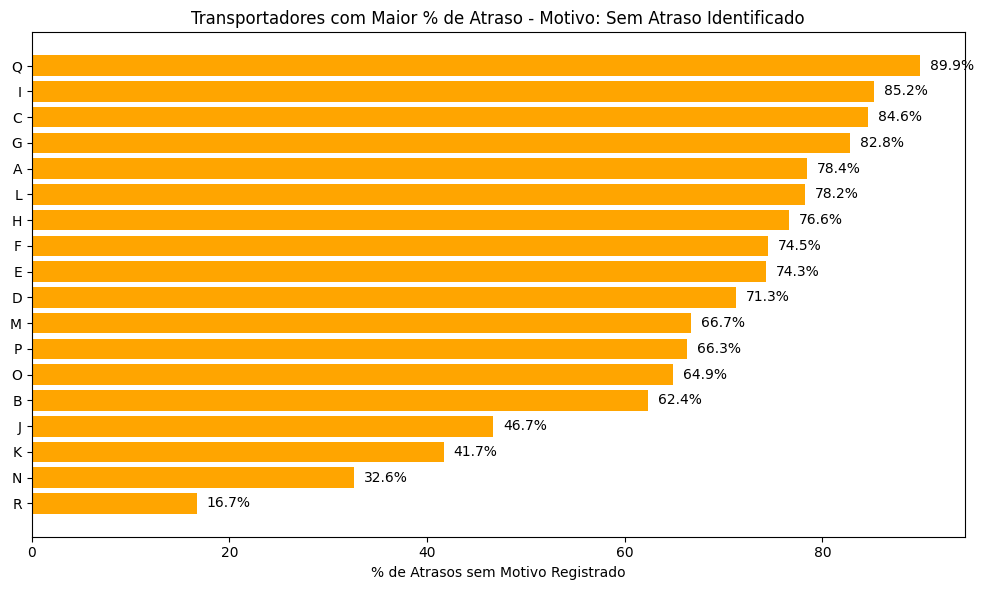

In [188]:
# Etapa 1 Filtra apenas pedidos com atraso e motivo "Sem Atraso Identificado"
df_filtrado = df_prep[(df_prep['atraso'] == 1) & (df_prep['MotivoMacro'] == 'Sem Atraso Identificado')]

# Etapa 2  Conta quantos pedidos com atraso e motivo "Sem Atraso Identificado" por transportador
contagem_sem_motivo = df_filtrado.groupby('Transportador')['Documento'].count()

# Etapa 3  Conta o total de pedidos com atraso por transportador
total_atraso_por_transportador = df_prep[df_prep['atraso'] == 1].groupby('Transportador')['Documento'].count()

# Etapa 4  Calcula o percentual
percentual_sem_motivo = (contagem_sem_motivo / total_atraso_por_transportador * 100).dropna().round(1)

# Etapa 5  Ordena decrescentemente
percentual_sem_motivo = percentual_sem_motivo.sort_values(ascending=False)

# Etapa 6  Plotando o gráfico
plt.figure(figsize=(10, 6))
bars = plt.barh(percentual_sem_motivo.index, percentual_sem_motivo.values, color='orange')
plt.xlabel('% de Atrasos sem Motivo Registrado')
plt.title('Transportadores com Maior % de Atraso - Motivo: Sem Atraso Identificado')

# Etapa 7  Adiciona os rótulos nas barras
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}%', va='center')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


##  Conclusões da Exploração de Dados do dataset final e respostas as hipoteses
*  A análise por dia da semana revela que quartas, sextas e domingos concentram os maiores percentuais de atraso, acima do terceiro quartil (Q3) da distribuição global.
*  A modalidade = Carro, concentra a maior parte dos motivos de atraso com 80% do total;.

* A transportadora Q possue a maior representatividade de atraso sem identificação de motivo

*   91,1% dos pedidos foram entregues no prazo, porém apenas 89,80% foram pedidos que tiveram o caminho "feliz" (sem insucesso).
*   7,5% dos atrasos estão concentrados em até 5 dias.

Abaixo, mostra a concentração e o motivo de insucessos que levaram os pedidos serem entregues **FORA DO PRAZO** do cliente.

*   Cliente = 1,40 pp
*   Transporte = 0,70 pp
*   Loja = 0,10 pp
*   Pendencia = 0,10 pp
*   CD = 0,00 pp
*   Roteirização = 0,00pp
*   Sem Atraso Identificado = 6,2 pp.

Totalizando em 8,9% de pedidos entregues fora do prazo.

Chego a conclusão da necessidade de revisão no processo de expedição e transporte. Analise apresentou pedidos sendo entregues para o cliente atrasados sem evidencia de insucesso.

## .4 Preparar o dataset para iniciar o modelo de ML (Regressão Logistica)

### Pre  processamento
Etapa sera necesaria para remoção de linhas nulas das colunas categoricas

In [189]:
# Quantificar nulos e não nulos
print("\nResumo de valores nulos e não nulos por coluna:")
null_counts_prep = df_prep.isnull().sum()
notnull_counts_prep = df_prep.notnull().sum()

df_null_summary_prep = pd.DataFrame({
    'Coluna': df_prep.columns,
    'Nulos': null_counts_prep.values,
    'Não Nulos': notnull_counts_prep.values
})

print(df_null_summary_prep)


Resumo de valores nulos e não nulos por coluna:
                 Coluna  Nulos  Não Nulos
0      Data_Performance      0      72204
1                Cidade      0      72204
2             Documento      0      72204
3                 Canal      0      72204
4         Transportador     15      72189
5          Modadalidade      0      72204
6         DataExpedicao    664      71540
7   DataLimiteExpedicao      0      72204
8        StatusDoPedido      0      72204
9    DataEntregaCliente      0      72204
10       DataIntegracao      0      72204
11               atraso      0      72204
12          dias_atraso      0      72204
13         faixa_atraso      0      72204
14          MotivoMacro      0      72204
15      MotivoDescricao      0      72204


Remover linha cuja as informações estão nulas da coluna Transportador

In [190]:
df_prep = df_prep.dropna(subset=['Transportador'])

In [191]:
# Quantificar nulos e não nulos
print("\nResumo de valores nulos e não nulos por coluna:")
null_counts_prep = df_prep.isnull().sum()
notnull_counts_prep = df_prep.notnull().sum()

df_null_summary_prep = pd.DataFrame({
    'Coluna': df_prep.columns,
    'Nulos': null_counts_prep.values,
    'Não Nulos': notnull_counts_prep.values
})

print(df_null_summary_prep)


Resumo de valores nulos e não nulos por coluna:
                 Coluna  Nulos  Não Nulos
0      Data_Performance      0      72189
1                Cidade      0      72189
2             Documento      0      72189
3                 Canal      0      72189
4         Transportador      0      72189
5          Modadalidade      0      72189
6         DataExpedicao    664      71525
7   DataLimiteExpedicao      0      72189
8        StatusDoPedido      0      72189
9    DataEntregaCliente      0      72189
10       DataIntegracao      0      72189
11               atraso      0      72189
12          dias_atraso      0      72189
13         faixa_atraso      0      72189
14          MotivoMacro      0      72189
15      MotivoDescricao      0      72189


Remover colunas de Datas

In [192]:
# Remover colunas de Datas
df_prep = df_prep.drop(columns=['Data_Performance', 'DataExpedicao', 'DataLimiteExpedicao', 'DataEntregaCliente', 'DataIntegracao'])

### Seleção dos dados

In [193]:
# Seleciona apenas linhas com valor de 'atraso' preenchido
df_modelo = df_prep.dropna(subset=['atraso'])

# Define X e y
X = df_modelo.drop(columns=['atraso'])
y = df_modelo['atraso']


###  Codificar variáveis categóricas (One-Hot)

In [194]:
# Identifica colunas categóricas automaticamente
colunas_categoricas = X.select_dtypes(include=['object', 'category']).columns.tolist()

# One-hot encoding nas categóricas
X_encoded = pd.get_dummies(X, columns=colunas_categoricas, drop_first=True)


### Balancemanto da classe alvo
Foi identificado durante a etapa de pre processamento a necessidade de balanceamento. Não irei utilizar RandomUnderSampler porque irei perder muitos dados. Seguirei com o metodo SMOTE.

In [195]:
# Remove colunas datetime, se ainda existirem no dataset codificado
X_encoded_clean = X_encoded.select_dtypes(exclude=['datetime', 'datetimetz'])


In [196]:
#Utilização do SMOTE para balancear
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_encoded_clean, y)

In [197]:
#Verificação de como ficou.
print("Distribuição após SMOTE:", Counter(y_bal))

Distribuição após SMOTE: Counter({False: 65785, True: 65785})


### Divisão dos dados
Divisão dos dados em treino, validação e teste para posteriomente rodar no modelo de ML.

In [198]:
# 60% treino, 20% validação, 20% teste
X_train, X_temp, y_train, y_temp = train_test_split(X_bal, y_bal, test_size=0.4, random_state=42, stratify=y_bal)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


### Padronizar variáveis numéricas
Utilização do StandardScaler

In [199]:
# Padronização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


In [200]:
X_train_scaled

array([[ 0.04568054,  0.23943286, -0.00355917, ...,  0.27616402,
        -0.01283374, -0.00355917],
       [ 0.33321922, -0.56606069, -0.00355917, ...,  0.27616402,
        -0.01283374, -0.00355917],
       [ 0.52589949, -0.56606069, -0.00355917, ...,  0.27616402,
        -0.01283374, -0.00355917],
       ...,
       [-0.96501512, -0.16331392, -0.00355917, ...,  0.27616402,
        -0.01283374, -0.00355917],
       [-1.11231649, -0.56606069, -0.00355917, ...,  0.27616402,
        -0.01283374, -0.00355917],
       [ 1.1203431 ,  0.23943286, -0.00355917, ...,  0.27616402,
        -0.01283374, -0.00355917]])

In [201]:
X_val_scaled

array([[ 0.92192654, -0.56606069, -0.00355917, ...,  0.27616402,
        -0.01283374, -0.00355917],
       [-0.00636242, -0.56606069, -0.00355917, ...,  0.27616402,
        -0.01283374, -0.00355917],
       [ 1.22731595, -0.56606069, -0.00355917, ...,  0.27616402,
        -0.01283374, -0.00355917],
       ...,
       [ 0.42444694,  0.23943286, -0.00355917, ...,  0.27616402,
        -0.01283374, -0.00355917],
       [ 0.85219631,  0.64217964, -0.00355917, ...,  0.27616402,
        -0.01283374, -0.00355917],
       [-0.77588134, -0.56606069, -0.00355917, ...,  0.27616402,
        -0.01283374, -0.00355917]])

In [202]:
X_test_scaled

array([[ 1.54763402, -0.56606069, -0.00355917, ...,  0.27616402,
        -0.01283374, -0.00355917],
       [ 0.64792714, -0.56606069, -0.00355917, ...,  0.27616402,
        -0.01283374, -0.00355917],
       [-1.41086571, -0.56606069, -0.00355917, ...,  0.27616402,
        -0.01283374, -0.00355917],
       ...,
       [-0.20651277, -0.16331392, -0.00355917, ...,  0.27616402,
        -0.01283374, -0.00355917],
       [-0.8887013 ,  0.64217964, -0.00355917, ...,  0.27616402,
        -0.01283374, -0.00355917],
       [ 0.84523599, -0.56606069, -0.00355917, ...,  0.27616402,
        -0.01283374, -0.00355917]])